# 1. Librerias Necesarias

In [84]:
# Data manipulation
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2


# Model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Adam optimizer
from tensorflow.keras.optimizers import Adam

# Saving models and encoders
import joblib

# SHAP for model interpretation
import shap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Cargar Datos 

In [45]:
# Load the preprocessed training data
train_df = pd.read_csv('data/train_preprocessed.csv')

# Display the first few rows
train_df.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,text_length,text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,317,hi im isaac im going writing face mars natural...
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,210,perspective think face natural landform dont t...
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,105,think face natural landform life mars descover...
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,362,life mars would know reason think natural land...
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,101,people thought face formed alieans thought lif...


# 3. Manejar Valores Faltantes

In [46]:
# Check for missing values
print("Missing values in each column:")
print(train_df.isnull().sum())

# Drop rows with any missing values
train_df = train_df.dropna()
print("\nAfter dropping missing values, shape:", train_df.shape)

Missing values in each column:
discourse_id               0
essay_id                   0
discourse_text             0
discourse_type             0
discourse_effectiveness    0
text_length                0
text                       8
dtype: int64

After dropping missing values, shape: (36757, 7)


# 4. Encode Labels y Features

In [47]:
# Initialize LabelEncoder
le = LabelEncoder()

# Encode the target variable
y = le.fit_transform(train_df['discourse_effectiveness'])

# Save the label encoder for future use
joblib.dump(le, 'encoders/label_encoder.pkl')

# Display the classes
print("Classes:", le.classes_)

Classes: ['Adequate' 'Effective' 'Ineffective']


# 5. Feature Engineering

## 5.1 Text Vectorization

In [48]:
# Initialize TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit and transform the 'text' column
X_text = tfidf.fit_transform(train_df['text'])

# Save the TfidfVectorizer
joblib.dump(tfidf, 'encoders/tfidf_vectorizer.pkl')

['encoders/tfidf_vectorizer.pkl']

## 5.2 Escalar Texto

In [49]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the 'text_length' column
X_length = scaler.fit_transform(train_df[['text_length']])

# Save the scaler
joblib.dump(scaler, 'encoders/standard_scaler.pkl')

['encoders/standard_scaler.pkl']

## 5.3 One-Hot Encode Discourse Type

In [51]:
# Initialize OneHotEncoder
ohe = OneHotEncoder(drop='first')

# Fit and transform the 'discourse_type' column
X_discourse = ohe.fit_transform(train_df[['discourse_type']])

# Save the OneHotEncoder
joblib.dump(ohe, 'encoders/onehot_encoder.pkl')

# Get feature names for OneHotEncoder
discourse_feature_names = ohe.get_feature_names_out(['discourse_type'])

## 5.4 Concatenate All Features

In [52]:
import scipy.sparse as sp

# Concatenate all features
X = sp.hstack([X_text, X_length, X_discourse])

print("Feature matrix shape:", X.shape)

Feature matrix shape: (36757, 5007)


# 6. Dividir data en Entrenamiento y Validación

In [53]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (29405, 5007)
Validation set shape: (7352, 5007)


In [69]:
# Compute class weights to handle class imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.5841975602972146, 1: 1.3137202341062413, 2: 1.8973415924635437}


# 7. Modelo de Keras

In [96]:
def create_improved_nn_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

    model.add(Dense(num_classes, activation='softmax'))
    return model

num_classes = len(le.classes_)
improved_nn_model = create_improved_nn_model(X_train.shape[1], num_classes)
optimizer = Adam(learning_rate=0.001)

# Compile the model
improved_nn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Display the model architecture
improved_nn_model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 256)            │     1,282,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,325,187 (5.06 MB)

 Trainable params: 1,324,291 (5.05 MB)

 Non-trainable params: 896 (3.50 KB)

## 8. Entrenar modelo

In [97]:
# Define EarlyStopping with reduced patience
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model with class weights
history = improved_nn_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3962 - loss: 2.1577 - val_accuracy: 0.6434 - val_loss: 1.5497
Epoch 2/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4651 - loss: 1.5503 - val_accuracy: 0.6638 - val_loss: 1.4081
Epoch 3/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5164 - loss: 1.3579 - val_accuracy: 0.5949 - val_loss: 1.3052
Epoch 4/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5516 - loss: 1.2474 - val_accuracy: 0.5539 - val_loss: 1.2516
Epoch 5/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5747 - loss: 1.1596 - val_accuracy: 0.5734 - val_loss: 1.2023
Epoch 6/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6052 - loss: 1.0847 - val_accuracy: 0.5660 - val_loss: 1.1897
Epoch 7/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6232 - loss: 1.0414 - val_accuracy: 0.5562 - val_loss: 1.2061
Epoch 8/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6428 - loss: 1.0082 - val_accu

# 9. Evaluar Modelo

## 9.1 Historia de Entrenamiento

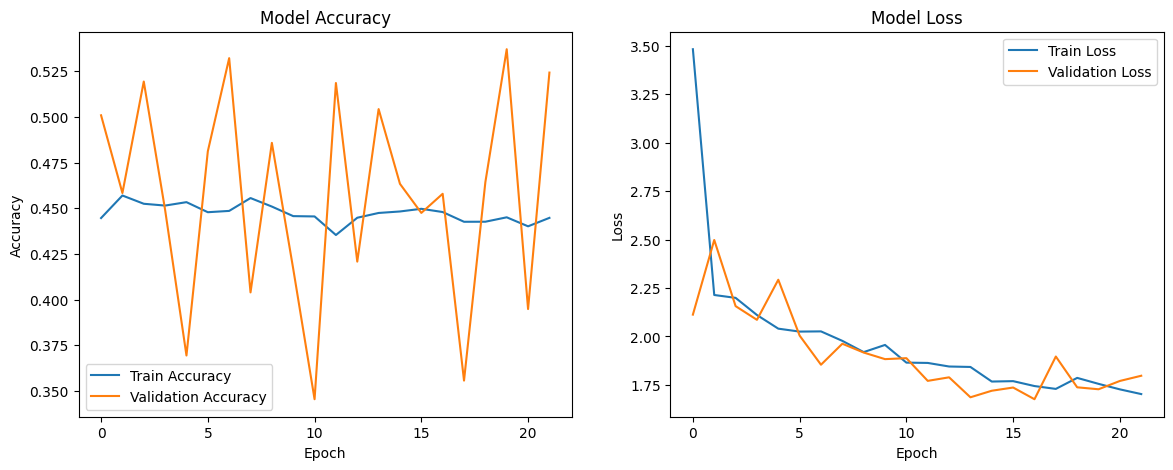

In [94]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(14,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 9.2 Matriz de Confusión

230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


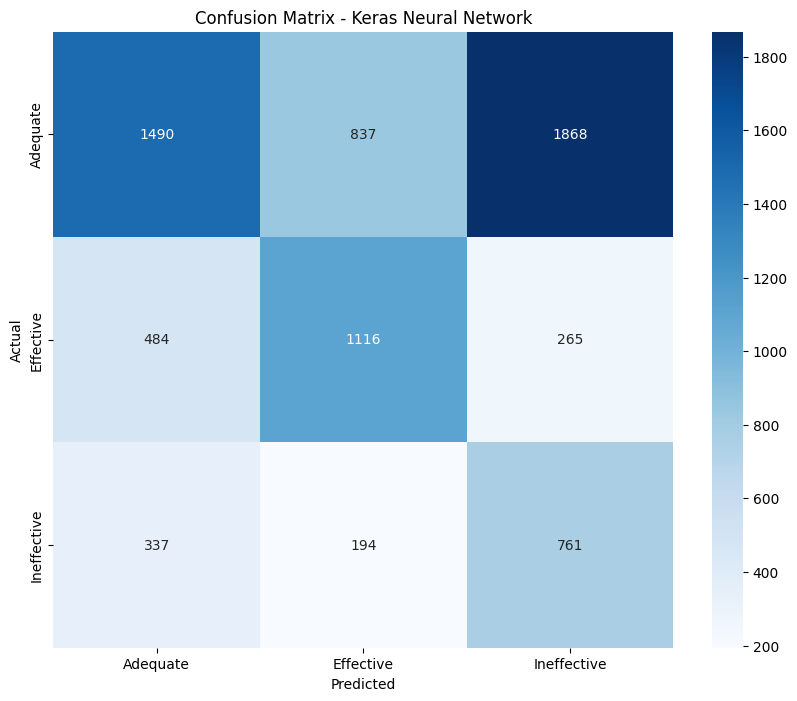

Classification Report:
              precision    recall  f1-score   support

    Adequate       0.64      0.36      0.46      4195
   Effective       0.52      0.60      0.56      1865
 Ineffective       0.26      0.59      0.36      1292

    accuracy                           0.46      7352
   macro avg       0.48      0.51      0.46      7352
weighted avg       0.55      0.46      0.47      7352

Accuracy: 0.45797062023939067


In [95]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Predict on validation set
y_pred_probs = improved_nn_model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Keras Neural Network')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=le.classes_))
print("Accuracy:", accuracy_score(y_val, y_pred))